In [3]:
# SAVE 데이터 로드
import os
os.chdir('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from module.util_main import downsampling, dim_reduct
from collections import defaultdict
font = {'size': 16, 'family':"Malgun Gothic"}
matplotlib.rc('font', **font)

from pathlib import Path

### 에너지 데이터 로드
SAVE = pd.read_csv('data/SAVE/power_0428.csv', index_col=0)
SAVE = SAVE.iloc[84:,:]
SAVE.index = pd.to_datetime(SAVE.index)
SAVE[SAVE == 0] = np.nan
SAVE = SAVE.loc[pd.to_datetime('2017-01-01 00:00'):,:]

helper_dict = defaultdict(list)
for col in SAVE.columns:
    helper_dict[col[2:]].append(col)

# 동일 집끼리 병합
drop_cols = []
invalid_idx_list = []
for key,value in helper_dict.items():
    if len(value) >= 2:
        valid_idx_1 = ~pd.isnull(SAVE[value[1]])

        # replace value
        SAVE[value[0]][valid_idx_1] = SAVE[value[1]][valid_idx_1]

        # delete remain
        drop_cols.append(value[1])

# drop cols
SAVE.drop(columns = drop_cols, inplace = True)

# label과 data의 column 맞춤
SAVE.columns = [c[2:] for c in SAVE.columns]

### 라벨 로드
SAVE_label = pd.read_csv('data/SAVE/save_household_survey_data_v0-3.csv', index_col = 0)
# Interviedate가 빠른 순으로 정렬
SAVE_label.sort_values('InterviewDate', inplace = True)
SAVE_label = SAVE_label.T
SAVE_label.columns = SAVE_label.columns.astype(str)

# 라벨 순서를 데이터 순서와 맞춤
valid_col = []
for col in SAVE.columns:
    if col in SAVE_label.columns:
        valid_col.append(col)

SAVE_label = SAVE_label[valid_col].T
SAVE = SAVE[valid_col]
print('Done load SAVE')
SAVE[SAVE == 0] = np.nan

# CER 데이터 로드
# %% load dataset
# start_date = pd.to_datetime('2010-09-01 00:00:00')
# end_date = pd.to_datetime('2009-12-01 23:00:00')

power_df = pd.read_csv('data/CER/power_comb_SME_included.csv')

# 0 to NaN
power_df[power_df==0] = np.nan
power_df['time'] = pd.to_datetime(power_df['time'])
power_df.set_index('time', inplace=True)

# load label
CER_label = pd.read_csv('data/CER/survey_processed_0427.csv')
CER_label['ID'] = CER_label['ID'].astype(str)
CER_label.set_index('ID', inplace=True)

CER = power_df.loc[:,CER_label.index]
del power_df
print('Done load CER')

## 기간을 6개월 한정
start_date = pd.to_datetime('2018-01-01 00:00:00')
end_date = pd.to_datetime('2018-06-30 23:45:00')

SAVE = SAVE.loc[start_date:end_date,:]

start_date = pd.to_datetime('2010-01-01 00:00:00')
end_date = pd.to_datetime('2010-06-30 23:30:00')

CER = CER.loc[start_date:end_date,:]

# Downsampling SAVE
n = SAVE.shape[0]
list_ = []
time_ = []
for i in range(0, n, 2):
    data = SAVE.iloc[i:i+2,:]
    invalid_data_idx = np.any(pd.isnull(data), axis=0)
    data = data.sum(axis=0)
    data.iloc[invalid_data_idx] = np.nan
    list_.append(data)
    time_.append(SAVE.index[i])
list_ = pd.concat(list_, axis=1).T
list_.index = time_
SAVE = list_
del list_

# load ETRI
ETRI = pd.read_csv('data/ETRI/label_0427.csv', index_col=0)
ETRI.index = pd.to_datetime(ETRI.index)
start_date = pd.to_datetime('2018-01-01 00:00:00')
end_date = pd.to_datetime('2018-06-30 23:00:00')
ETRI = ETRI.loc[start_date:end_date,:]
ETRI_label = pd.read_csv('data/ETRI/survey_0427.csv', index_col = 0)
ETRI[ETRI == 0] = np.nan

nan_ratio = pd.isnull(SAVE).sum(axis=0) / SAVE.shape[0]
invalid_idx = (nan_ratio == 1)
SAVE = SAVE.loc[:,~invalid_idx]
SAVE_label = SAVE_label.loc[~invalid_idx,:]

# invalid house processing
nan_ratio = pd.isnull(CER).sum(axis=0) / CER.shape[0]
invalid_idx = (nan_ratio == 1)
CER = CER.loc[:,~invalid_idx]
CER_label = CER_label.loc[~invalid_idx,:]

print(CER.shape)
print(CER_label.shape)

nan_ratio = pd.isnull(ETRI).sum(axis=0) / ETRI.shape[0]
invalid_idx = (nan_ratio == 1)
ETRI = ETRI.loc[:,~invalid_idx]
ETRI_label = ETRI_label.T.loc[~invalid_idx,:]

print(SAVE.shape)
print(CER.shape)


Done load SAVE
Done load CER
(8688, 3248)
(3248, 15)
(8688, 3192)
(8688, 3248)


## downsampling

In [14]:
# Downsampling SAVE
n = SAVE.shape[0]
list_ = []
time_ = []
for i in range(0, n, 2):
    data = SAVE.iloc[i:i+2,:]
    invalid_data_idx = np.any(pd.isnull(data), axis=0)
    data = data.sum(axis=0)
    data.iloc[invalid_data_idx] = np.nan
    list_.append(data)
    time_.append(SAVE.index[i])
list_ = pd.concat(list_, axis=1).T
list_.index = time_
SAVE = list_
del list_

# Downsampling CER
n = CER.shape[0]
list_ = []
time_ = []
for i in range(0, n, 2):
    data = CER.iloc[i:i+2,:]
    invalid_data_idx = np.any(pd.isnull(data), axis=0)
    data = data.mean(axis=0)
    data.iloc[invalid_data_idx] = np.nan
    list_.append(data)
    time_.append(CER.index[i])
list_ = pd.concat(list_, axis=1).T
list_.index = time_
CER = list_
del list_


In [15]:
def transform(df, sampling_interv = 24 * 2 * 7):
    '''
    [input]
    df: dataframe (timeseries, home)
    
    [output]
    data_2d: 2d array
    home_arr: home index array
    '''

    # dataframe => 3d numpy array
    n_d, n_h = df.shape
    n_w = n_d // sampling_interv
    n_d = n_w * sampling_interv
    df_rs = df.iloc[:n_d,:].values.T.reshape(n_h, -1, sampling_interv)

    # 3d numpy array => 2d numpy array
    n, m, l = df_rs.shape
    data_2d = df_rs.reshape(n*m, l)
    home_arr = np.repeat(np.arange(0, n), m)
    invalid_idx = np.any(pd.isnull(data_2d), axis=1)
    data_2d = data_2d[~invalid_idx, :]
    home_arr = home_arr[~invalid_idx]

    # constant load filtering
    invalid_idx = np.nanmin(data_2d, axis=1) == np.nanmax(data_2d, axis=1)
    data_2d = data_2d[~invalid_idx, :]
    home_arr = home_arr[~invalid_idx]

    return data_2d, home_arr

# 2d daily 형태로 변환 (house * day , hour)
# CER_rs, home_arr_c = transform(CER, 24 * 2)
# SAVE_rs, home_arr_s = transform(SAVE, 24 * 2)
CER_rs, home_arr_c = transform(CER, 24)
SAVE_rs, home_arr_s = transform(SAVE, 24)
ETRI_rs, home_arr_e = transform(ETRI, 24)


In [16]:
data_dict = dict()

for name in ['CER','SAVE','ETRI']:
    if name == 'CER':
        data_raw = CER_rs
        label_raw = CER_label['Q13'].values
        home_arr = home_arr_c
    elif name == 'ETRI':
        data_raw = ETRI_rs
        label_raw = ETRI_label['popl_num'].values
        home_arr = home_arr_e
    elif name == 'SAVE':
        data_raw = SAVE_rs
        label_raw = SAVE_label['Q2'].values
        home_arr = home_arr_s

    invalid_idx = pd.isnull(label_raw)
    # label_raw = label_raw[~invalid_idx]
    invalid_home_num = np.where(invalid_idx)[0]
    valid_home_idx = np.zeros(home_arr.shape, dtype = bool)
    for j in range(home_arr.shape[0]):
        if home_arr[j] in invalid_home_num:
            valid_home_idx[j] = False
        else:
            valid_home_idx[j] = True
    data_raw = data_raw[valid_home_idx,:]
    home_arr = home_arr[valid_home_idx]
    unique_home_arr = np.unique(home_arr)
    label = np.array([label_raw[u] for u in unique_home_arr])

    data_dict[name] = [data_raw, label, home_arr]
    

## Typical daily load profile
1. 6 month average
2. proposed

In [5]:
import multiprocessing
from functools import partial
import time

data_raw, label, home_arr = data_dict['CER']

def helper(i):
    idx = home_arr == i
    data = data_raw[idx,:]
    n_samples = data.shape[0]
    distance = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            distance[i, j] = np.linalg.norm(data[i,:]-data[j,:])

    # rep_load_idx = np.argmin(distance.sum(axis=0))
    return distance

PROCESSES = multiprocessing.cpu_count()
print('{}개의 CPU 사용...'.format(PROCESSES))

start = time.time()
if __name__ == '__main__':
    
    unique_home_arr = np.unique(home_arr)
    p = multiprocessing.Pool(processes = PROCESSES)
    distance_list = p.map(helper, unique_home_arr)

end = time.time()
print('Elapsed {:.2f} hours..'.format((end - start) / 3600))


rocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/ubuntu/anaconda3/envs/mskim/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/ubuntu/anaconda3/envs/mskim/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/ubuntu/anaconda3/envs/mskim/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/ubuntu/anaconda3/envs/mskim/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-5-e6c1c3505aa0>", line 14, in helper
    distance[i, j] = np.linalg.norm(data[i,:]-data[j,:])
  File "<ipython-input-5-e6c1c3505aa0>", line 14, in helper
    distance[i, j] = np.linalg.norm(data[i,:]-data[j,:])
  File "/home/ubuntu/anaconda3/envs/mskim/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/ubuntu/a

KeyboardInterrupt: 

In [ ]:
rep_load_dict = dict()

rep_load_list = []
for i, home_idx in enumerate(unique_home_arr):
    distance = distance_list[i].mean(axis=0)
    mean_ = distance.mean()
    std_ = np.sqrt(distance.var())
    data = data_raw[home_arr == home_idx,:]

    idx = distance <= mean_ - 0.1 * std_

    data = data[idx,:]
    rep_load_list.append(data.mean(axis=0))

rep_load_dict['proposed'] = np.array(rep_load_list)

rep_load_list = []
for i, home_idx in enumerate(unique_home_arr):
    data = data_raw[home_arr == home_idx,:]
    rep_load_list.append(data.mean(axis=0))

rep_load_dict['avg'] = np.array(rep_load_list)


In [50]:
from sklearn.metrics import mean_absolute_error

# data_ex = feature_extraction(rep_load_dict['proposed']).T
# data_concat = np.concatenate([rep_load_dict['proposed'], CER_ex], axis=1)
# data_2d = rep_load_dict['proposed']
data_2d = rep_load_dict['avg']
# data_2d = data_concat
# data_2d = CER_ex

kf = KFold(n_splits=5, shuffle = True, random_state = 0)
result_tmp = np.zeros(label.shape)
for train_index, test_index in kf.split(data_2d):
    X_train, X_test = data_2d[train_index], data_2d[test_index]
    y_train, y_test = label[train_index], label[test_index]

    rfc = RandomForestRegressor(n_jobs = -1)
    # rfc = SVC(kernel='rbf', degree=3)
    rfc.fit(X_train, y_train)
    rfc_predict = rfc.predict(X_test)
    result_tmp[test_index] = rfc_predict

result_mae = mean_absolute_error(label, result_tmp)
print(result_mae)



0.9006043786617329


## 일단 average로 진행

In [17]:
rep_load_dict = dict()
label_dict = dict()
for name in ['CER','ETRI','SAVE']:
    data_raw, label, home_arr = data_dict[name]
    unique_home_arr = np.unique(home_arr)
    rep_load_list = []
    for i, home_idx in enumerate(unique_home_arr):
        data = data_raw[home_arr == home_idx,:]
        rep_load_list.append(data.mean(axis=0))
    rep_load_dict[name] = np.array(rep_load_list)
    label_dict[name] = label


ipykernel_launcher:24: RuntimeWarning: divide by zero encountered in log2
ipykernel_launcher:24: RuntimeWarning: divide by zero encountered in log2


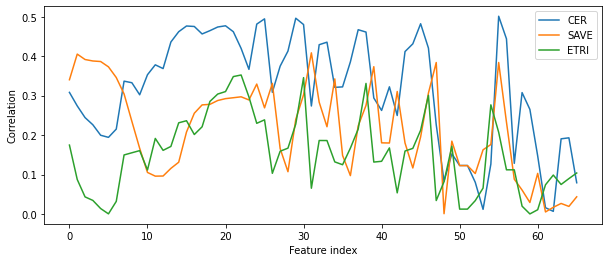

In [85]:
plt.figure(figsize = (10, 4))
for name in ['CER','SAVE', 'ETRI']:
    data_ex = feature_extraction_v2(rep_load_dict[name]).T
    data_concat = np.concatenate([rep_load_dict[name], data_ex], axis=1)
    rep_load_dict[name + '_concat'] = data_concat
    _, corr_, _ = evaluate_features(data_concat, label_dict[name])
    plt.plot(corr_, label = name)
    # print(corr_)

plt.legend()
plt.xlabel('Feature index')
plt.ylabel('Correlation')
plt.show()



## PCA

In [98]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(rep_load_dict['CER'])

cer_pca  = pca.transform(rep_load_dict['CER'])
save_pca = pca.transform(rep_load_dict['SAVE'])
etri_pca = pca.transform(rep_load_dict['ETRI'])


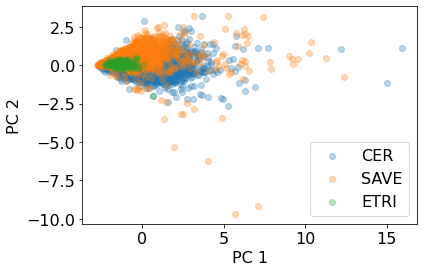

In [101]:
plt.scatter(cer_pca[:,0], cer_pca[:,1], label = 'CER', alpha = 0.3)
plt.scatter(save_pca[:,0], save_pca[:,1], label = 'SAVE' , alpha = 0.3)
plt.scatter(etri_pca[:,0], etri_pca[:,1], label = 'ETRI' , alpha = 0.3)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()


## Feature selection

In [163]:
from sklearn.metrics import f1_score

Xs, Ys, Xt, Yt = rep_load_dict['CER'][:,20:], label_dict['CER'], rep_load_dict['SAVE'][:,20:], label_dict['SAVE']
Ys = Ys.copy()
Yt = Yt.copy()

Ys[Ys<=2] = 0
Ys[Ys>2] = 1
Yt[Yt<=2] = 0
Yt[Yt>2] = 1

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(Xs, Ys.ravel())

Xt1, Xt2, Yt1, Yt2  = train_test_split(Xt, Yt, train_size=0.75, random_state=42, shuffle = True)
Yt_pred = clf.predict(Xt2)
print((Yt2 == Yt_pred).mean())
print(f1_score(Yt2, Yt_pred, average='binary'))

clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(Xt1, Yt1)
Yt_pred= clf.predict(Xt2)
print((Yt2 == Yt_pred).mean())
print(f1_score(Yt2, Yt_pred, average='binary'))


0.6
0.35918367346938773
0.5872611464968153
0.5423728813559323


In [158]:
v, c = np.unique(Yt2, return_counts = True)
c / c.sum()

array([0.56050955, 0.43949045])

In [150]:
v, c = np.unique(Yt, return_counts = True)

In [151]:
c / c.sum()

array([0.55414013, 0.44585987])

In [145]:
rep_load_dict['CER'].shape

(3243, 24)

## TCA

In [113]:
import numpy as np
import scipy.io
import scipy.linalg
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [126]:
from sklearn.model_selection import train_test_split
# from module.util_main import TCA
Xs, Ys, Xt, Yt = rep_load_dict['CER_concat'], label_dict['CER'], rep_load_dict['ETRI_concat'], label_dict['ETRI']
Ys = Ys.copy()
Yt = Yt.copy()

Ys[Ys<=2] = 0
Ys[Ys>2] = 1

Yt[Yt<=2] = 0
Yt[Yt>2] = 1

# Split target data
Xt1, Xt2, Yt1, Yt2  = train_test_split(Xt, Yt, train_size=0.75, random_state=42, shuffle = True)

# Create latent space and evaluate using Xs and Xt1
tca = TCA(kernel_type='linear', dim=10, lamb=1, gamma=1)
acc1, ypre1 = tca.fit_predict(Xs, Ys, Xt1, Yt1)

# Project and evaluate Xt2 existing projection matrix and classifier
acc2, ypre2 = tca.fit_predict_new(Xt1, Xs, Ys, Xt2, Yt2)


In [127]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(Xs_new, Ys.ravel())

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0])

## OTDD

In [90]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'otdd')))
from otdd.pytorch.datasets import load_torchvision_data
from otdd.pytorch.distance import DatasetDistance

src_name = 'CER'
tgt_name = 'SAVE'

data_src, label_src = rep_load_dict[src_name + '_concat'][:,10:20], label_dict[src_name].copy()
label_src[label_src<=2] = 0
label_src[label_src>2] = 1

data_tgt, label_tgt = rep_load_dict[tgt_name + '_concat'][:,10:20], label_dict[tgt_name].copy()
label_tgt[label_tgt<=2] = 0
label_tgt[label_tgt>2] = 1

# Load data
loaders_src  = load_torchvision_data(data = data_src, label = label_src, valid_size=0, maxsize=data_src.shape[0])[0]
loaders_tgt  = load_torchvision_data(data = data_tgt, label = label_tgt,  valid_size=0, maxsize=data_tgt.shape[0])[0]

# Instantiate distance
dist = DatasetDistance(loaders_src['train'], loaders_tgt['train'],
                          inner_ot_method = 'exact',
                          debiased_loss = True,
                          p = 2, entreg = 1e-1,
                          device='cpu')

d = dist.distance(maxsamples = 1000)
print(f'OTDD({src_name},{tgt_name})={d:8.2f}')


Fold Sizes: 2594/649 (train/test)
Fold Sizes: 2512/628 (train/test)


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

OTDD(CER,SAVE)=    1.71


In [22]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def evaluate_features(data_2d, label, is_categorical = False):
    mi_result = np.zeros((data_2d.shape[1], ))
    corr_result = np.zeros((data_2d.shape[1], ))
    feature_importance_result = np.zeros((data_2d.shape[1], ))

    for i in range(data_2d.shape[1]):
        data = data_2d[:,i]

        '''
        1. MI
        '''
        val, count = np.unique(label, return_counts=True)
        prob = count / count.sum()

        sig_ = np.std(data)
        H_X = 1 / 2 * np.log2(2 * np.pi * np.e * sig_ ** 2)

        H_con = 0
        for ii, v in enumerate(val):
            sig_ = np.std(data[label == v])
            H_con += (1 / 2 * np.log2(2 * np.pi * np.e * sig_ ** 2)) * prob[ii]
        MI = H_X - H_con

        '''
        2. Corr
        '''
        if is_categorical and list(val)!=[0,1]:
            corr_ = 0
            for ii, v in enumerate(val):
                corr_ += np.abs(np.corrcoef(np.ravel(data), np.ravel(label==v))[0,1]) * prob[ii]
        else:
            # print('Not categorical')
            corr_ = np.abs(np.corrcoef(np.ravel(data), np.ravel(label))[0,1])
        corr_result[i] = corr_
        mi_result[i] = MI

    '''
    3. Feature importance
    '''
    # kf = KFold(n_splits=5, shuffle = True, random_state = 0)
    # result_tmp = np.zeros(label.shape)
    # for train_index, test_index in kf.split(data_2d):
    #     X_train, X_test = data_2d[train_index], data_2d[test_index]
    #     y_train, y_test = label[train_index], label[test_index]

    #     rfc = RandomForestRegressor()
    #     # rfc = SVC(kernel='rbf', degree=3)
    #     rfc.fit(X_train, y_train)
    #     rfc_predict = rfc.predict(X_test)
    #     result_tmp[test_index] = rfc_predict
    #     break
    # feature_importance_result = rfc.feature_importances_

  
    return mi_result, corr_result, feature_importance_result


In [21]:
feature_names = ['c_total','c_day','c_morning','c_forenoon','c_noon','c_afternoon','c_evening','c_night',\
'c_total_max','c_day_max','c_morning_max','c_forenoon_max','c_noon_max','c_afternoon_max','c_evening_max','c_night_max',\
    'c_total_min','c_day_min','c_morning_min','c_forenoon_min','c_noon_min','c_afternoon_min','c_evening_min','c_night_min',\
    'r_mean_max','r_min_mean','r_forenoon_noon','r_afternoon_noon','r_evening_noon','r_noon_total','r_night_day',\
        'P_above_0','P_above_1','P_above_2',\
            'c_total_var','c_day_var','c_morning_var','c_forenoon_var','c_noon_var','c_afternoon_var','c_evening_var','c_night_var']

def feature_extraction(profile_allday):
    features = []
    '''
        mean features
    '''
    # 1. mean P, daily, all day : c_total
    feature = np.mean(profile_allday, axis=1)
    features.append(feature)

    # 4. mean P, 6 ~ 22 : c_day
    feature = np.mean(profile_allday[:, 2 * 6:2 * 22], axis=1)
    features.append(feature)

    # 5. mean P, 6 ~ 8.5: c_morning
    feature = np.mean(profile_allday[:, 2 * 6:2 * 8 + 1], axis=1)
    features.append(feature)

    # 6. mean P, 8.5 ~ 12: c_forenoon
    feature = np.mean(profile_allday[:, 2 * 8 + 1:2 * 12], axis=1)
    features.append(feature)

    # 7. mean P, 12 ~ 14.5: c_noon
    feature = np.mean(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1)
    features.append(feature)

    # 8. mean P, 14.5 ~ 18: c_afternoon
    feature = np.mean(profile_allday[:, 2 * 14 + 1:2 * 18], axis=1)
    features.append(feature)

    # 9. mean P, 18 ~ 24: c_evening
    feature = np.mean(profile_allday[:, 2 * 18:2 * 24], axis=1)
    features.append(feature)

    # 10. mean P, 00 ~ 6: c_night
    feature = np.mean(profile_allday[:, :2 * 6], axis=1)
    features.append(feature)

    '''
        max features
    '''
    # 1. max P, daily, all day : c_total
    feature = np.max(profile_allday, axis=1)
    features.append(feature)

    # 4. max P, 6 ~ 22 : c_day
    feature = np.max(profile_allday[:, 2 * 6:2 * 22], axis=1)
    features.append(feature)

    # 5. max P, 6 ~ 8.5: c_morning
    feature = np.max(profile_allday[:, 2 * 6:2 * 8 + 1], axis=1)
    features.append(feature)

    # 6. max P, 8.5 ~ 12: c_forenoon
    feature = np.max(profile_allday[:, 2 * 8 + 1:2 * 12], axis=1)
    features.append(feature)

    # 7. max P, 12 ~ 14.5: c_noon
    feature = np.max(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1)
    features.append(feature)

    # 8. max P, 14.5 ~ 18: c_afternoon
    feature = np.max(profile_allday[:, 2 * 14 + 1:2 * 18], axis=1)
    features.append(feature)

    # 9. max P, 18 ~ 24: c_evening
    feature = np.max(profile_allday[:, 2 * 18:2 * 24], axis=1)
    features.append(feature)

    # 10. max P, 00 ~ 6: c_night
    feature = np.max(profile_allday[:, :2 * 6], axis=1)
    features.append(feature)
    '''
        min
    '''
    # 1. min P, daily, all day : c_total
    feature = np.min(profile_allday, axis=1)
    features.append(feature)

    # 4. min P, 6 ~ 22 : c_day
    feature = np.min(profile_allday[:, 2 * 6:2 * 22], axis=1)
    features.append(feature)

    # 5. min P, 6 ~ 8.5: c_morning
    feature = np.min(profile_allday[:, 2 * 6:2 * 8 + 1], axis=1)
    features.append(feature)

    # 6. min P, 8.5 ~ 12: c_forenoon
    feature = np.min(profile_allday[:, 2 * 8 + 1:2 * 12], axis=1)
    features.append(feature)

    # 7. min P, 12 ~ 14.5: c_noon
    feature = np.min(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1)
    features.append(feature)

    # 8. min P, 14.5 ~ 18: c_afternoon
    feature = np.min(profile_allday[:, 2 * 14 + 1:2 * 18], axis=1)
    features.append(feature)

    # 9. min P, 18 ~ 24: c_evening
    feature = np.min(profile_allday[:, 2 * 18:2 * 24], axis=1)
    features.append(feature)

    # 10. min P, 00 ~ 6: c_night
    feature = np.min(profile_allday[:, :2 * 6], axis=1)
    features.append(feature)
    '''
        ratios
    '''
    # 1. mean P over max P
    feature = np.mean(profile_allday, axis=1) / np.max(profile_allday, axis=1)
    features.append(feature)

    # 2. min P over mean P
    feature = np.min(profile_allday, axis=1) / np.mean(profile_allday, axis=1)
    features.append(feature)

    # 3. c_forenoon / c_noon
    feature = np.mean(profile_allday[:, 2 * 8 + 1:2 * 12], axis=1) / \
              np.mean(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1)
    features.append(feature)

    # 4. c_afternoon / c_noon
    feature = np.mean(profile_allday[:, 2 * 8 + 1:2 * 12], axis=1) / \
              np.mean(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1)
    features.append(feature)

    # 5. c_evening / c_noon
    feature = np.mean(profile_allday[:, 2 * 18:2 * 24], axis=1) / \
              np.mean(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1)
    features.append(feature)

    # 6. c_noon / c_total
    feature = np.mean(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1) / \
              np.mean(profile_allday, axis=1)
    features.append(feature)

    # 7. c_night / c_day
    feature = np.mean(profile_allday[:, :2 * 6], axis=1) / \
              np.mean(profile_allday[:, 2 * 6:2 * 22], axis=1)
    features.append(feature)

    '''
        temporal properties
    '''
    # 1. P > 0.5
    feature = (profile_allday > 0.5).mean(axis=1)
    features.append(feature)

    # 1. P > 1
    feature = (profile_allday > 1).mean(axis=1)
    features.append(feature)

    # 1. P > 2
    feature = (profile_allday > 2).mean(axis=1)
    features.append(feature)

    '''
        statistical properties
    '''
    # 1. var P, daily, all day : c_total
    feature = np.var(profile_allday, axis=1)
    features.append(feature)

    # 4. var P, 6 ~ 22 : c_day
    feature = np.var(profile_allday[:, 2 * 6:2 * 22], axis=1)
    features.append(feature)

    # 5. var P, 6 ~ 8.5: c_morning
    feature = np.var(profile_allday[:, 2 * 6:2 * 8 + 1], axis=1)
    features.append(feature)

    # 6. var P, 8.5 ~ 12: c_forenoon
    feature = np.var(profile_allday[:, 2 * 8 + 1:2 * 12], axis=1)
    features.append(feature)

    # 7. var P, 12 ~ 14.5: c_noon
    feature = np.var(profile_allday[:, 2 * 12:2 * 14 + 1], axis=1)
    features.append(feature)

    # 8. var P, 14.5 ~ 18: c_afternoon
    feature = np.var(profile_allday[:, 2 * 14 + 1:2 * 18], axis=1)
    features.append(feature)

    # 9. var P, 18 ~ 24: c_evening
    feature = np.var(profile_allday[:, 2 * 18:2 * 24], axis=1)
    features.append(feature)

    # 10. var P, 00 ~ 6: c_night
    feature = np.var(profile_allday[:, :2 * 6], axis=1)
    features.append(feature)

    return np.array(features)

In [84]:
def feature_extraction_v2(profile_allday):
    features = []
    '''
        mean features
    '''
    # 1. mean P, daily, all day : c_total
    feature = np.mean(profile_allday, axis=1)
    features.append(feature)

    # 4. mean P, 6 ~ 22 : c_day
    feature = np.mean(profile_allday[:, 6:22], axis=1)
    features.append(feature)

    # 5. mean P, 6 ~ 8.5: c_morning
    feature = np.mean(profile_allday[:, 6:8], axis=1)
    features.append(feature)

    # 6. mean P, 8.5 ~ 12: c_forenoon
    feature = np.mean(profile_allday[:, 8:12], axis=1)
    features.append(feature)

    # 7. mean P, 12 ~ 14.5: c_noon
    feature = np.mean(profile_allday[:, 12:14], axis=1)
    features.append(feature)

    # 8. mean P, 14.5 ~ 18: c_afternoon
    feature = np.mean(profile_allday[:, 14:18], axis=1)
    features.append(feature)

    # 9. mean P, 18 ~ 24: c_evening
    feature = np.mean(profile_allday[:, 18:24], axis=1)
    features.append(feature)

    # 10. mean P, 00 ~ 6: c_night
    feature = np.mean(profile_allday[:, :6], axis=1)
    features.append(feature)

    '''
        max features
    '''
    # 1. max P, daily, all day : c_total
    feature = np.max(profile_allday, axis=1)
    features.append(feature)

    # 4. max P, 6 ~ 22 : c_day
    feature = np.max(profile_allday[:,  6: 22], axis=1)
    features.append(feature)

    # 5. max P, 6 ~ 8.5: c_morning
    feature = np.max(profile_allday[:, 6:8], axis=1)
    features.append(feature)

    # 6. max P, 8.5 ~ 12: c_forenoon
    feature = np.max(profile_allday[:, 8 : 12], axis=1)
    features.append(feature)

    # 7. max P, 12 ~ 14.5: c_noon
    feature = np.max(profile_allday[:, 12:14], axis=1)
    features.append(feature)

    # 8. max P, 14.5 ~ 18: c_afternoon
    feature = np.max(profile_allday[:, 14:18], axis=1)
    features.append(feature)

    # 9. max P, 18 ~ 24: c_evening
    feature = np.max(profile_allday[:,  18: 24], axis=1)
    features.append(feature)

    # 10. max P, 00 ~ 6: c_night
    feature = np.max(profile_allday[:, :6], axis=1)
    features.append(feature)
    '''
        min
    '''
    # 1. min P, daily, all day : c_total
    feature = np.min(profile_allday, axis=1)
    features.append(feature)

    # 4. min P, 6 ~ 22 : c_day
    feature = np.min(profile_allday[:, 6:22], axis=1)
    features.append(feature)

    # 5. min P, 6 ~ 8.5: c_morning
    feature = np.min(profile_allday[:, 6: 8], axis=1)
    features.append(feature)

    # 6. min P, 8.5 ~ 12: c_forenoon
    feature = np.min(profile_allday[:,  8: 12], axis=1)
    features.append(feature)

    # 7. min P, 12 ~ 14.5: c_noon
    feature = np.min(profile_allday[:, 12: 14], axis=1)
    features.append(feature)

    # 8. min P, 14.5 ~ 18: c_afternoon
    feature = np.min(profile_allday[:,  14: 18], axis=1)
    features.append(feature)

    # 9. min P, 18 ~ 24: c_evening
    feature = np.min(profile_allday[:, 18:24], axis=1)
    features.append(feature)

    # 10. min P, 00 ~ 6: c_night
    feature = np.min(profile_allday[:, : 6], axis=1)
    features.append(feature)
    '''
        ratios
    '''
    # 1. mean P over max P
    feature = np.mean(profile_allday, axis=1) / np.max(profile_allday, axis=1)
    features.append(feature)

    # 2. min P over mean P
    feature = np.min(profile_allday, axis=1) / np.mean(profile_allday, axis=1)
    features.append(feature)

    # 3. c_forenoon / c_noon
    feature = np.mean(profile_allday[:, 8: 12], axis=1) / \
              np.mean(profile_allday[:,  12:14], axis=1)
    features.append(feature)

    # 4. c_afternoon / c_noon
    feature = np.mean(profile_allday[:, 8: 12], axis=1) / \
              np.mean(profile_allday[:,  12:14], axis=1)
    features.append(feature)

    # 5. c_evening / c_noon
    feature = np.mean(profile_allday[:, 18:24], axis=1) / \
              np.mean(profile_allday[:,  12: 14], axis=1)
    features.append(feature)

    # 6. c_noon / c_total
    feature = np.mean(profile_allday[:,  12: 14], axis=1) / \
              np.mean(profile_allday, axis=1)
    features.append(feature)

    # 7. c_night / c_day
    feature = np.mean(profile_allday[:, :6], axis=1) / \
              np.mean(profile_allday[:,  6:22], axis=1)
    features.append(feature)

    '''
        temporal properties
    '''
    # 1. P > 0.5
    feature = (profile_allday > 0.5).mean(axis=1)
    features.append(feature)

    # 1. P > 1
    feature = (profile_allday > 1).mean(axis=1)
    features.append(feature)

    # 1. P > 2
    feature = (profile_allday > 2).mean(axis=1)
    features.append(feature)

    '''
        statistical properties
    '''
    # 1. var P, daily, all day : c_total
    feature = np.var(profile_allday, axis=1)
    features.append(feature)

    # 4. var P, 6 ~ 22 : c_day
    feature = np.var(profile_allday[:,  6: 22], axis=1)
    features.append(feature)

    # 5. var P, 6 ~ 8.5: c_morning
    feature = np.var(profile_allday[:,  6: 8 ], axis=1)
    features.append(feature)

    # 6. var P, 8.5 ~ 12: c_forenoon
    feature = np.var(profile_allday[:,  8: 12], axis=1)
    features.append(feature)

    # 7. var P, 12 ~ 14.5: c_noon
    feature = np.var(profile_allday[:, 12: 14], axis=1)
    features.append(feature)

    # 8. var P, 14.5 ~ 18: c_afternoon
    feature = np.var(profile_allday[:,  14: 18], axis=1)
    features.append(feature)

    # 9. var P, 18 ~ 24: c_evening
    feature = np.var(profile_allday[:, 18: 24], axis=1)
    features.append(feature)

    # 10. var P, 00 ~ 6: c_night
    feature = np.var(profile_allday[:, : 6], axis=1)
    features.append(feature)

    return np.array(features)